# Scrublet doublet removal analysis on the full dataset

In [2]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import pandas as pd
import scanpy as sc
import umap

In [266]:
metadata = pd.read_csv('/mnt/2021Jan/01_MGT_2021_Samples.txt', sep = '\t', index_col = 0)

In [268]:
metadata = metadata[165:170]

In [269]:
path = '/mnt/2021Jan/'
filenames = metadata.index

In [270]:
filenames

Index(['WTDAtest7770716', 'WTDAtest7770717', 'WTDAtest7770718',
       'WTDAtest7770719'],
      dtype='object', name='Sanger sample ID')

In [271]:
def applyScrubblet(sampleName, rootPath):
    # read in matrix
    E = scipy.io.mmread(rootPath + sampleName +'_soupx_out/' + 'matrix.mtx').T.tocsc() 
    #genes = np.array(scr.load_genes(rootPath +'outs_'+ sampleName + '/filtered_feature_bc_matrix/' + 'features.tsv.gz', delimiter='\t', column=1))
    barcodes = pd.read_csv(rootPath + sampleName +'_soupx_out/'+  'barcodes.tsv', delimiter='\t', header=None)
    #print('Counts matrix shape: {} rows, {} columns'.format(E.shape[0], E.shape[1]))
    #print('Number of genes in gene list: {}'.format(len(genes)))
    
    # apply scrubblet
    total_counts = E.sum(1).A.squeeze()

    #fig, ax = plt.subplots(figsize = (10, 5))
    #ax.hist(total_counts, bins = np.logspace(3, 5, 40))
    #ax.set_xscale('log')
    #ax.set_xlabel('Total counts')
    #ax.set_ylabel('Number of cells')
    
    #plt.savefig("/mnt/2021Jan/scrublet_results/sample_" +sampleName+ ".png")
    
    #calculate doublet scores
    scrub = scr.Scrublet(E, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          min_gene_variability_pctl=85, 
                                                          n_prin_comps=30)
    
    scrub.call_doublets(threshold=0.25)
    scrub.plot_histogram();

    print('Running UMAP...')
    scrub.set_embedding('UMAP', scr.get_umap(scrub.manifold_obs_, 10, min_dist=0.3))
    print('Done.')

    #save the plots & calculations
    #plt.savefig("/mnt/2021Jan/scrublet_results/UMAP_"+sampleName +".png")
        
    res = pd.DataFrame([barcodes.iloc[:,0], doublet_scores,predicted_doublets],
                      index=["barcode", "doublet_scores","predicted_doublets"]).T
    res.barcode = res.barcode + "-" + sampleName
    
    res.to_csv("/mnt/2021Jan/scrublet_results/file_" + sampleName +".csv")
    return res

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.33
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 26.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.7%
Elapsed time: 1.5 seconds
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 28.3%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 2.5%
Running UMAP...
Done.
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.39
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 3.1%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 6.3%
Elapsed time: 1.5 seconds
Detected doublet rate = 1.0%
Estimated detectable doublet fraction = 11.0%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.3%
Running UMAP...
Done.
Preprocessing...
Simulating doublets...
Embed

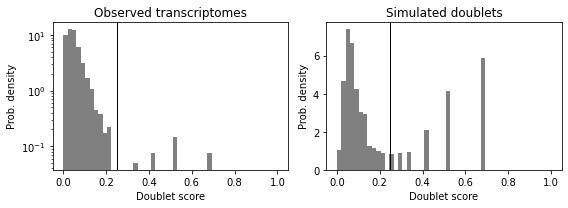

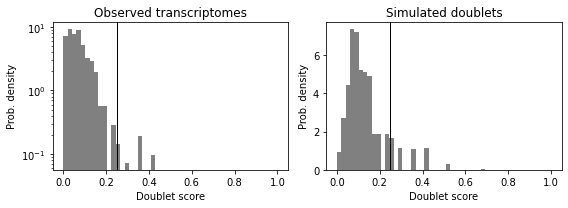

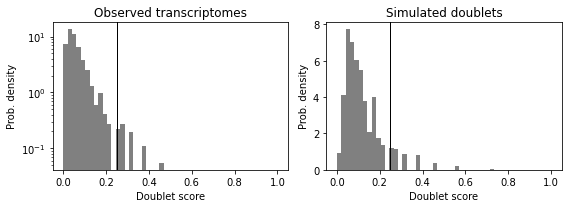

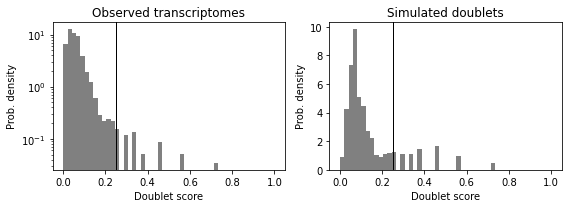

In [272]:
all_scrub_results = [applyScrubblet(file, path) for file in filenames]

#calculate doublet scores
    scrub = scr.Scrublet(E, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=2, 
                                                          min_cells=3, 
                                                          n_prin_comps=30)

In [273]:
frame = pd.DataFrame()
list_ = []
import os
for file in os.listdir("/mnt/2021Jan/scrublet_results/"):
    if file.endswith(".csv"):
        df = pd.read_csv(os.path.join("/mnt/2021Jan/scrublet_results/", file))
        list_.append(df)
        frame = pd.concat(list_)

In [274]:
frame

,Unnamed: 0,barcode,doublet_scores,predicted_doublets,Unnamed: 0.1
0,0,AAACCTGAGGAGCGAG-1-Human_colon_16S8123916,0.031658,False,NaN
1,1,AAACCTGAGGCATTGG-1-Human_colon_16S8123916,0.040000,False,NaN
2,2,AAACCTGAGTGGGATC-1-Human_colon_16S8123916,0.048402,False,NaN
3,3,AAACCTGCATGCAATC-1-Human_colon_16S8123916,0.034755,False,NaN
4,4,AAACCTGCATTAGCCA-1-Human_colon_16S8123916,0.097068,False,NaN
...,...,...,...,...,...
4958,4958,TTTGTCAGTTCCAACA-1-Human_colon_16S8123911,0.048865,False,NaN
4959,4959,TTTGTCAGTTGGGACA-1-Human_colon_16S8123911,0.090435,False,NaN
4960,4960,TTTGTCATCATCACCC-1-Human_colon_16S8123911,0.109772,False,NaN
4961,4961,TTTGTCATCCCAAGAT-1-Human_colon_16S8123911,0.174922,False,NaN


In [275]:
frame.to_csv("/mnt/2021Jan/scrublet_results/all_scores_together02.csv")

### all_scores_together contain the cell barcodes and the doublet value. load it into the adata and check doublet score distribution on the final integrated umap. Default threshold used for the filtering of possible doublets